In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit.quantum_info import SparsePauliOp, entanglement_of_formation, DensityMatrix

from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA
from scipy.optimize import minimize


import numpy as np
import matplotlib.pyplot as plt


from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import InstructionProperties

from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.primitives import Estimator
from qiskit_aer.primitives import EstimatorV2 as EstimatorAer
from qiskit_aer import AerSimulator


from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2,
    SamplerV2 as Sampler,
    EstimatorOptions
)


from qiskit.visualization import plot_distribution


from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.transformers import FreezeCoreTransformer



from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint


from entanglement_measures import GHZ_entanglmenetlike_measure, Multipartite_Negativity, multipartite_entanglement

import multiprocessing as mp


In [16]:
TOKEN = "c969ef6706b30cef0669a46aff24f9c495d1a52e7632d03f1ede94cc6bd97fbc190d1cc5d23f1b914a448ea60b42c26f831f321bb7e0e151be887061d3139254"

QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token= TOKEN,
    set_as_default=True,
    # Use `overwrite=True` if you're updating your token.
    overwrite=True,
)
 
# Load saved credentials
service = QiskitRuntimeService()

# First Part: Initialize and compare results with different mappings

# Initialize the hamiltonian problem

In [ ]:
#First we create the Hamiltonian as an observable of pauli matrices 
from qiskit.quantum_info import negativity, mutual_information

def initialize_H2_vqe_chemical(ri= 0.735, mapper= JordanWignerMapper()):
    """
    ri : float_like : inter atomic distance between the two Hydrogen atoms
    mapper : MapperLike: The mapping utilized from a a^daga <---> qubits
    """

    #initialize the hamiltonian
    driver = PySCFDriver(atom=f"H 0 0 0; H 0 0 {ri}", basis="sto-3g")
    problem = driver.run()
    hamiltonian = problem.hamiltonian.second_q_op()

    # we utilize the parity mapper to XLR8 things... and map it to pauli matrices
    mapper = ParityMapper(num_particles=(problem.num_alpha, problem.num_beta)) 
    pauli_hamiltonian = mapper.map(hamiltonian)

    #Ansatz Generation
    init_state = HartreeFock(problem.num_spatial_orbitals,
                         problem.num_particles,
                         mapper)

    ansatz = UCCSD(problem.num_spatial_orbitals,
               problem.num_particles,
               mapper,
               initial_state= init_state)
    
    #we will return the ansatz, pauli and the ES problem
    return ansatz, pauli_hamiltonian, problem



def vqe_chemical_ansatz(estimator, ansatz, problem, mapper=JordanWignerMapper(), optimizer= SLSQP()):
    
    #we generate the VQE algorithm
    vqe = VQE(estimator= estimator,
              ansatz= ansatz,
              optimizer= optimizer)
    
    #we define again the parity mapper: Maybe we can fix this (?)
    mapper = ParityMapper(num_particles=(problem.num_alpha, problem.num_beta))

    #we initialize the initial point
    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problem
    vqe.initial_point = initial_point.to_numpy_array()


    #We deploy the VQE algorithm
    solver = GroundStateEigensolver(mapper, vqe)


    result = solver.solve(problem)

    gs_energy = result.total_energies[0]
    utilized_ansatz = result.groundstate[0]
    optimized_parameters = result.groundstate[1]

    optimal_ansatz = utilized_ansatz.assign_parameters(optimized_parameters)

    #we return the groundstate energy and the optimal circuit ansatz
    return gs_energy, optimal_ansatz



def equilibrium_config(swept_interval, estimator):

    #we try to optimize this for running in parallel but
    # it does not seems to be poosible
    with mp.Pool() as pool:

        num_calc = len( swept_interval )

        EoF_list_max = np.zeros(num_calc)

        negativity_list_max = np.zeros(num_calc)

        mut_info = np.zeros(num_calc)

        energiesH2_list = np.zeros(num_calc)


        for i, d in enumerate(swept_interval):

            ansatz_h2, pauli_ham_h2, prob = initialize_H2_vqe_chemical(ri=d)

            gs_energy_d, optimal_ansatz_d = vqe_chemical_ansatz(estimator=estimator,
                                                                ansatz= ansatz_h2,
                                                                problem= prob)
            

            rho = DensityMatrix(optimal_ansatz_d)
        
            energiesH2_list[i] = gs_energy_d

            EoF_list_max[i] = entanglement_of_formation(rho)            
            
            negativity_list_max[i] = negativity(state= rho, qargs=[1])

            mut_info[i] = mutual_information(rho)


        return energiesH2_list, EoF_list_max, negativity_list_max, mut_info

        



In [45]:
def equilibrium_config(swept_interval, estimator):

    # Inicialización de los resultados
    num_calc = len(swept_interval)
    EoF_list_max = np.zeros(num_calc)
    negativity_list_max = np.zeros(num_calc)
    mut_info = np.zeros(num_calc)
    energiesH2_list = np.zeros(num_calc)

    # Calcula cada valor en el intervalo de barrido
    for i, d in enumerate(swept_interval):

        # Inicialización de los ansatz y problema
        ansatz_h2, pauli_ham_h2, prob = initialize_H2_vqe_chemical(ri=d)

        # Ejecuta VQE y obtén la energía y ansatz óptimo
        gs_energy_d, optimal_ansatz_d = vqe_chemical_ansatz(estimator=estimator,
                                                            ansatz=ansatz_h2,
                                                            problem=prob)

        # Calcula la matriz de densidad y las medidas de entrelazamiento
        rho = DensityMatrix(optimal_ansatz_d)
        energiesH2_list[i] = gs_energy_d
        EoF_list_max[i] = entanglement_of_formation(rho)
        negativity_list_max[i] = negativity(state=rho, qargs=[1])
        mut_info[i] = mutual_information(rho)

    # Retorna solo los cuatro arreglos esperados
    return energiesH2_list, EoF_list_max, negativity_list_max, mut_info

# Uso de la función
from qiskit.primitives import Estimator

distances = np.arange(0.05, 4.5, 0.05)
estimator = Estimator()

# Llamada a la función y almacenamiento de los resultados
energiesH2, entgmax, negmax, mut_info = equilibrium_config(swept_interval=distances, estimator=estimator)


In [41]:

from qiskit.primitives import Estimator

distances = np.arange(0.05, 4.5, 0.05)

estimator = Estimator()

energiesH2, entgmax, negmax, mut_info = equilibrium_config(swept_interval= distances, estimator= estimator)


ValueError: too many values to unpack (expected 4)

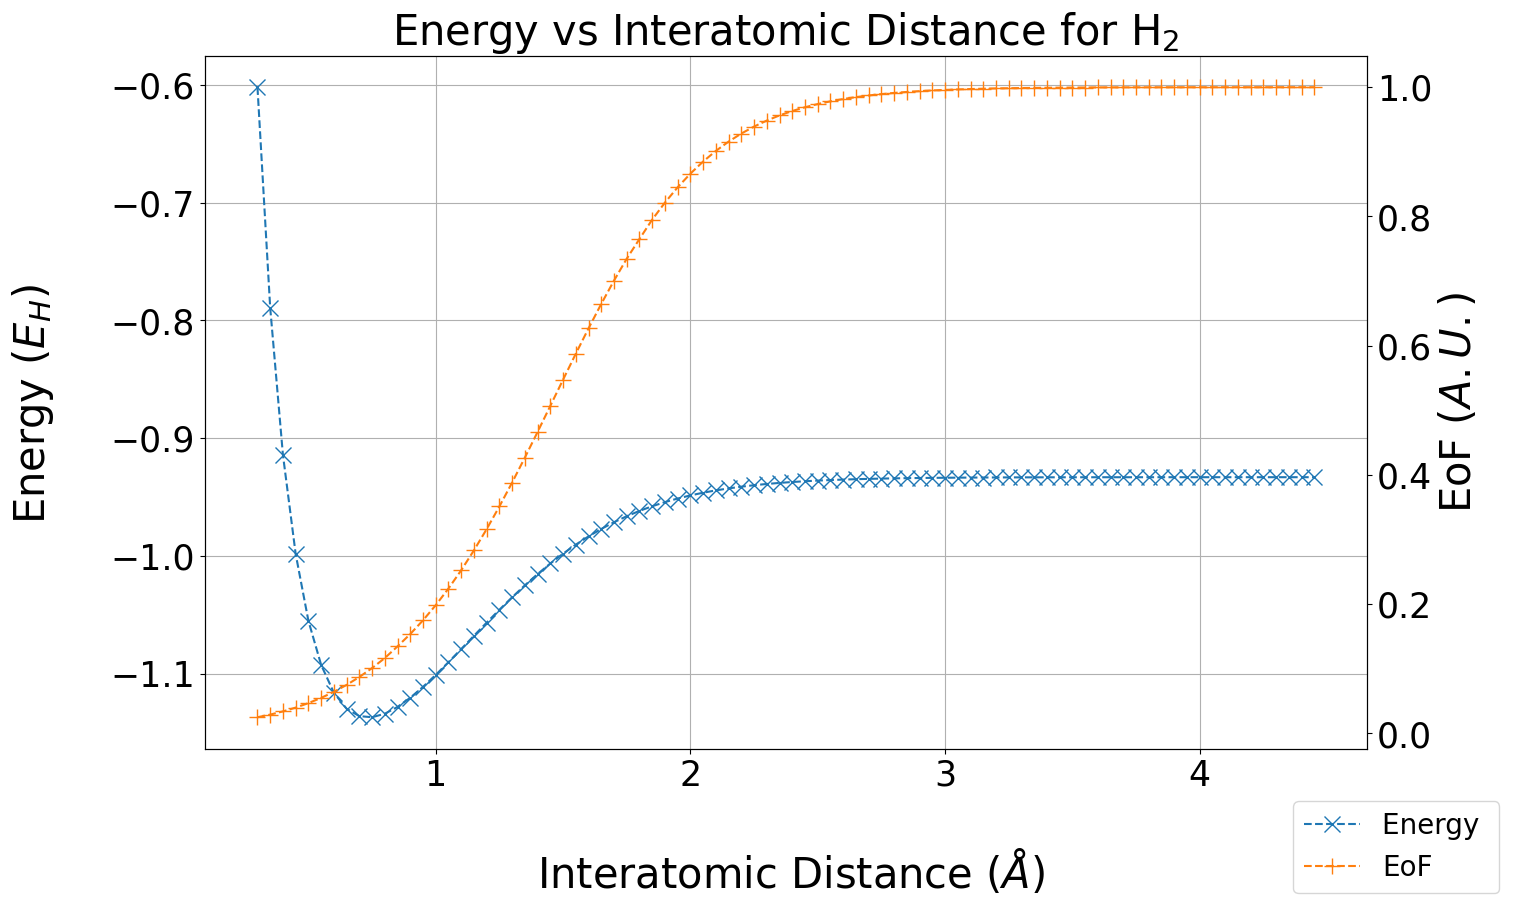

In [46]:
fig, ax1 = plt.subplots(figsize=(15, 9))


ax1.plot(distances[5:], energiesH2[5:], marker='x', linestyle='--', label= 'Energy ', markersize= 12)

ax1.set_xlabel('\n Interatomic Distance ($\AA$) ', fontsize= 30 )
ax1.set_ylabel('Energy ($E_H$) \n', fontsize= 30)
#ax1.set_title('State Distances vs Internuclear Distance\n', fontsize= 40)
ax1.grid(True)
ax1.tick_params(axis='y')
ax1.set_title(r'Energy vs Interatomic Distance for $ \text{H}_2$', fontsize= 30)
plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here



ax2 = ax1.twinx()

ax2.plot(distances[5:], entgmax[5:], marker='+', linestyle='--',label= 'EoF' , markersize= 12, color= 'tab:orange')
ax2.set_ylabel('EoF ($A.U.$)',  fontsize= 30)
ax2.tick_params(axis= 'y')



fig.legend( loc='lower right' ,fontsize= 20)
plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here


#fig.tight_layout()
plt.show()

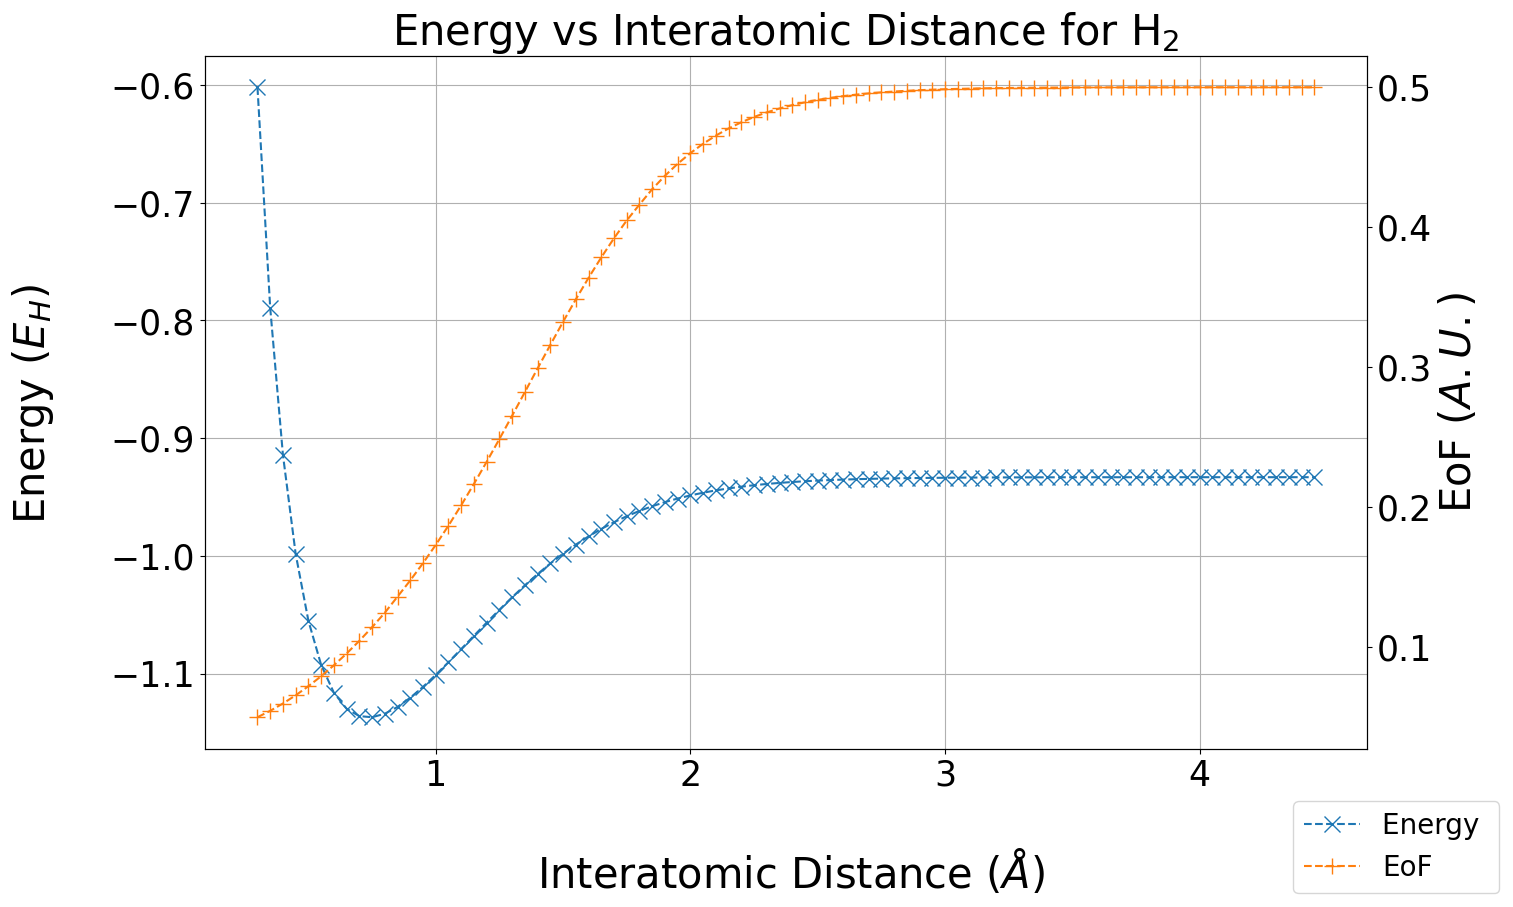

In [ ]:
fig, ax1 = plt.subplots(figsize=(15, 9))


ax1.plot(distances[5:], energiesH2[5:], marker='x', linestyle='--', label= 'Energy ', markersize= 12)

ax1.set_xlabel('\n Interatomic Distance ($\AA$) ', fontsize= 30 )
ax1.set_ylabel('Energy ($E_H$) \n', fontsize= 30)
#ax1.set_title('State Distances vs Internuclear Distance\n', fontsize= 40)
ax1.grid(True)
ax1.tick_params(axis='y')
ax1.set_title(r'Energy vs Interatomic Distance for $ \text{H}_2$', fontsize= 30)
plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here



ax2 = ax1.twinx()

ax2.plot(distances[5:], negmax[5:], marker='+', linestyle='--',label= 'EoF' , markersize= 12, color= 'tab:orange')
ax2.set_ylabel('EoF ($A.U.$)',  fontsize= 30)
ax2.tick_params(axis= 'y')



fig.legend( loc='lower right' ,fontsize= 20)
plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here


#fig.tight_layout()
plt.show()

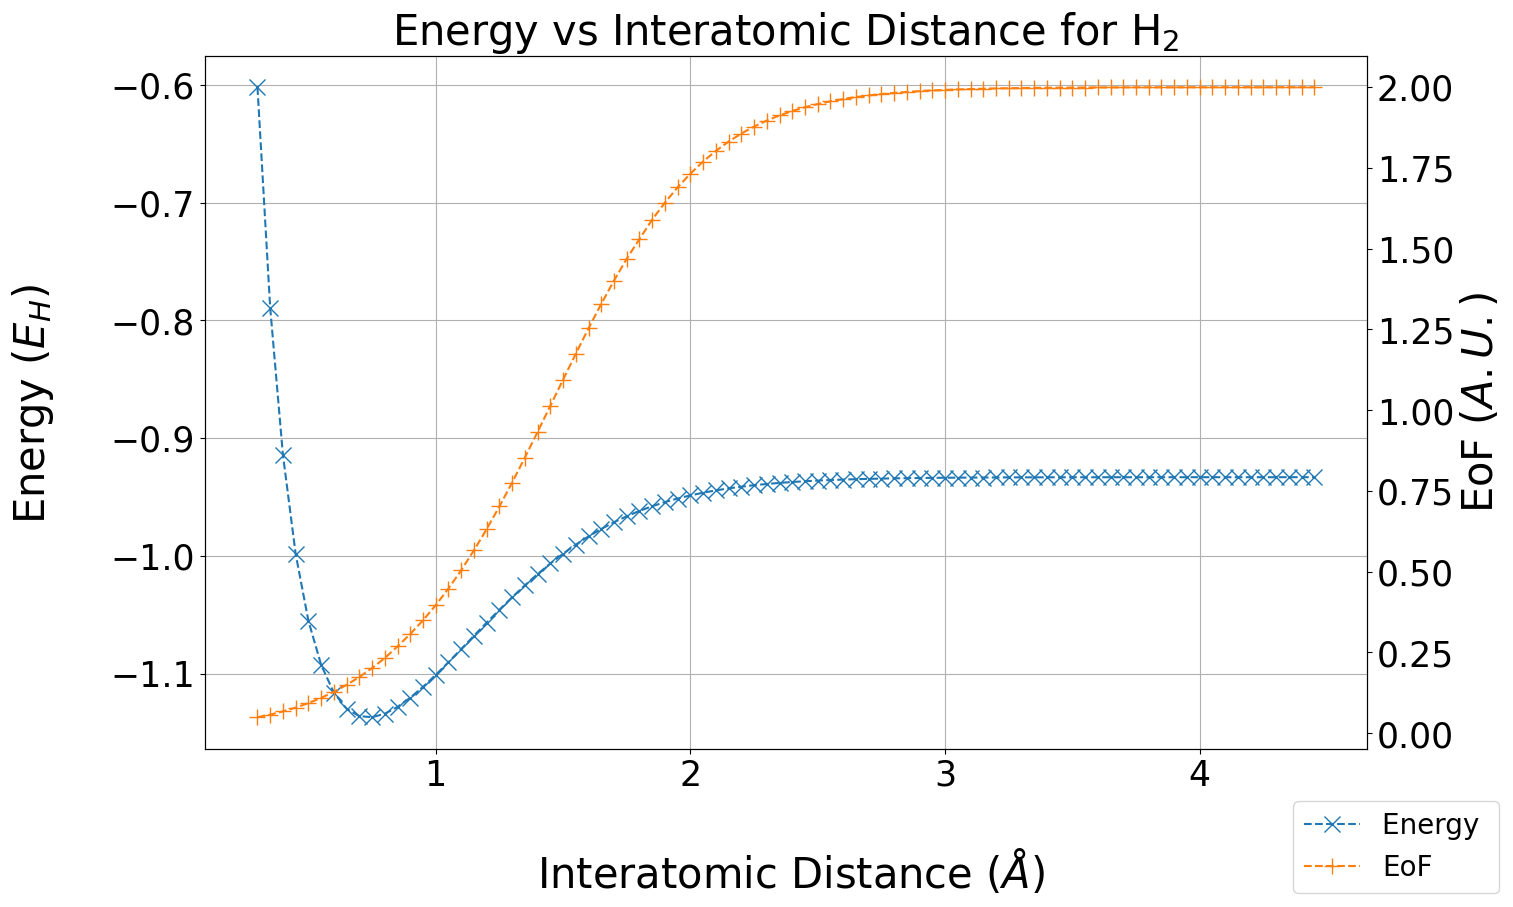

In [48]:
fig, ax1 = plt.subplots(figsize=(15, 9))


ax1.plot(distances[5:], energiesH2[5:], marker='x', linestyle='--', label= 'Energy ', markersize= 12)

ax1.set_xlabel('\n Interatomic Distance ($\AA$) ', fontsize= 30 )
ax1.set_ylabel('Energy ($E_H$) \n', fontsize= 30)
#ax1.set_title('State Distances vs Internuclear Distance\n', fontsize= 40)
ax1.grid(True)
ax1.tick_params(axis='y')
ax1.set_title(r'Energy vs Interatomic Distance for $ \text{H}_2$', fontsize= 30)
plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here



ax2 = ax1.twinx()

ax2.plot(distances[5:], mut_info[5:], marker='+', linestyle='--',label= 'EoF' , markersize= 12, color= 'tab:orange')
ax2.set_ylabel('EoF ($A.U.$)',  fontsize= 30)
ax2.tick_params(axis= 'y')



fig.legend( loc='lower right' ,fontsize= 20)
plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here


#fig.tight_layout()
plt.show()

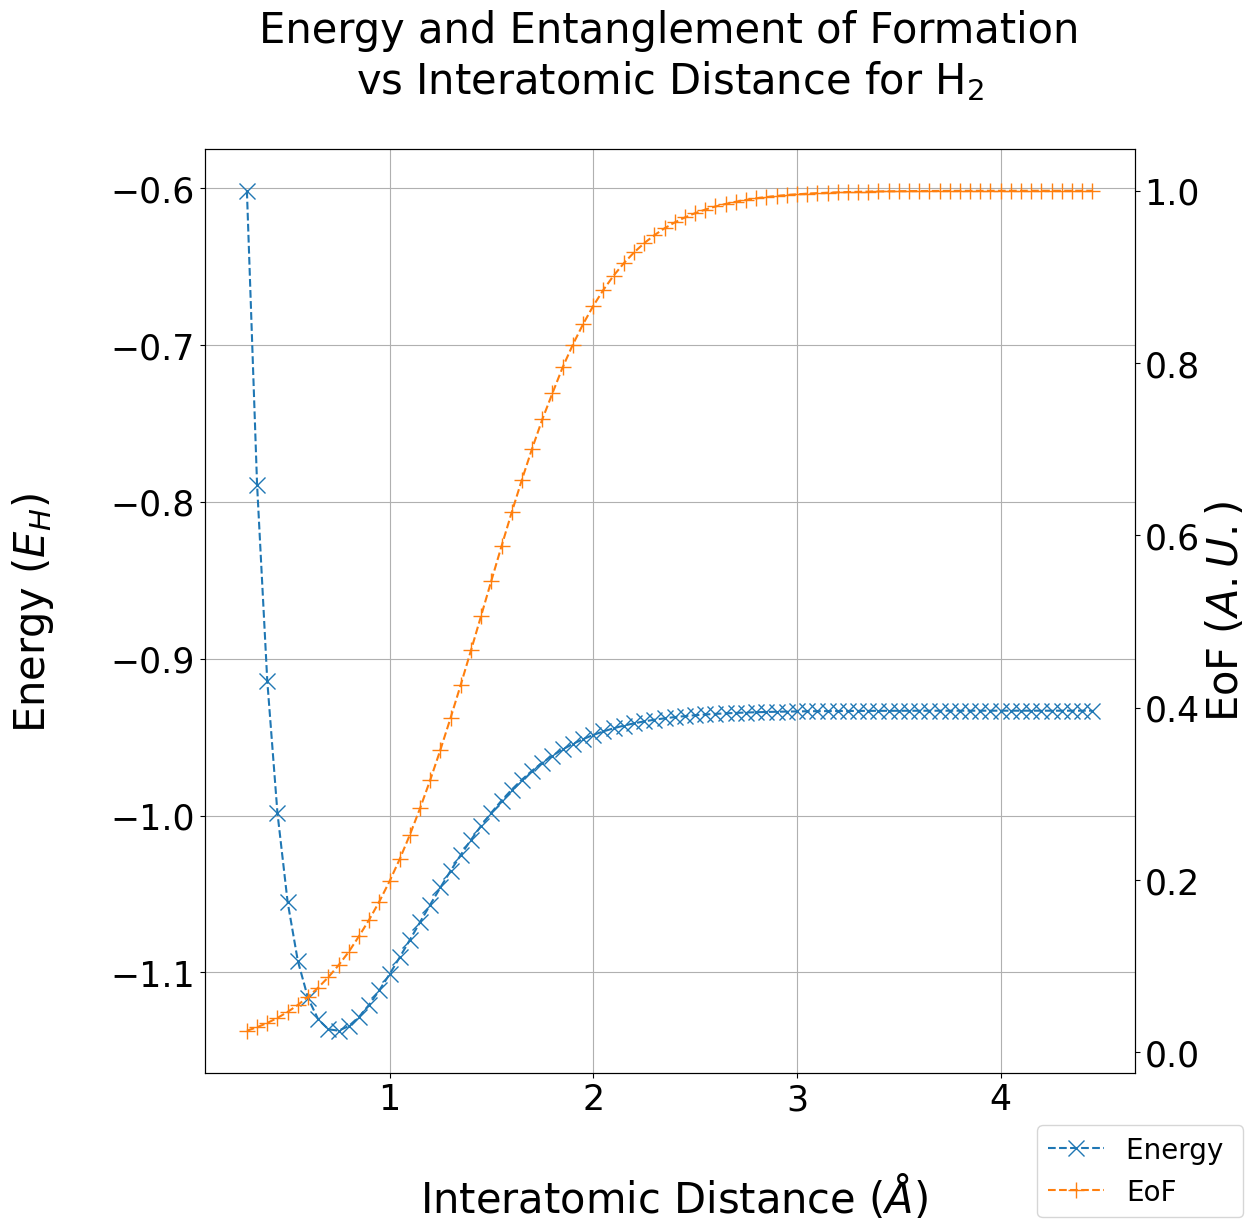

In [28]:
fig, ax1 = plt.subplots(figsize=(12, 12))


ax1.plot(distances[5:], energiesH2[5:], marker='x', linestyle='--', label= 'Energy ', markersize= 12)

ax1.set_xlabel('\n Interatomic Distance ($\AA$) ', fontsize= 30 )
ax1.set_ylabel('Energy ($E_H$) \n', fontsize= 30)
#ax1.set_title('State Distances vs Internuclear Distance\n', fontsize= 40)
ax1.grid(True)
ax1.tick_params(axis='y')
ax1.set_title(r'Energy and Entanglement of Formation' + '\n' + r'vs Interatomic Distance for $\text{H}_2$', fontsize=30, pad=40)


plt.tick_params(axis='both', which='major', labelsize=25)  # Cambia el tamaño de la etiqueta aquí



ax2 = ax1.twinx()

ax2.plot(distances[5:], entgmax[5:], marker='+', linestyle='--',label= 'EoF' , markersize= 12, color= 'tab:orange')
ax2.set_ylabel('EoF ($A.U.$)',  fontsize= 30)
ax2.tick_params(axis= 'y')



fig.legend( loc='lower right' ,fontsize= 20)
plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here


# Guardar la figura como SVG
plt.savefig('energy_entanglement_h2.svg', format='svg', bbox_inches='tight')

#fig.tight_layout()
plt.show()

# Lets do the same wiht a bigger resolution...

In [ ]:
distances = np.arange(0.05, 4, 0.05)

estimator = Estimator()


energiesH2_pt2, entgmax_pt2, entgtotal_pt2, negmax_pt2, negtotal_pt2, ghzmeasure_pt2 = run_calculation_for_gs(swept_interval= distances, estimator= estimator)

/tmp/ipykernel_33393/3199483918.py:93: ComplexWarning: Casting complex values to real discards the imaginary part
  negativity_list_max[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'max')
/tmp/ipykernel_33393/3199483918.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  negativity_list_total[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'total')


In [38]:
ansatz_h2, pauli_ham_h2, prob = initialize_H2_vqe_chemical(intermolecular_distance= 0.735)

gs_energy_d_equilibrium, optimal_ansatz_d_equilibrium = vqe_chemical_ansatz(estimator=estimator,
                                                                ansatz= ansatz_h2,
                                                                problem= prob)


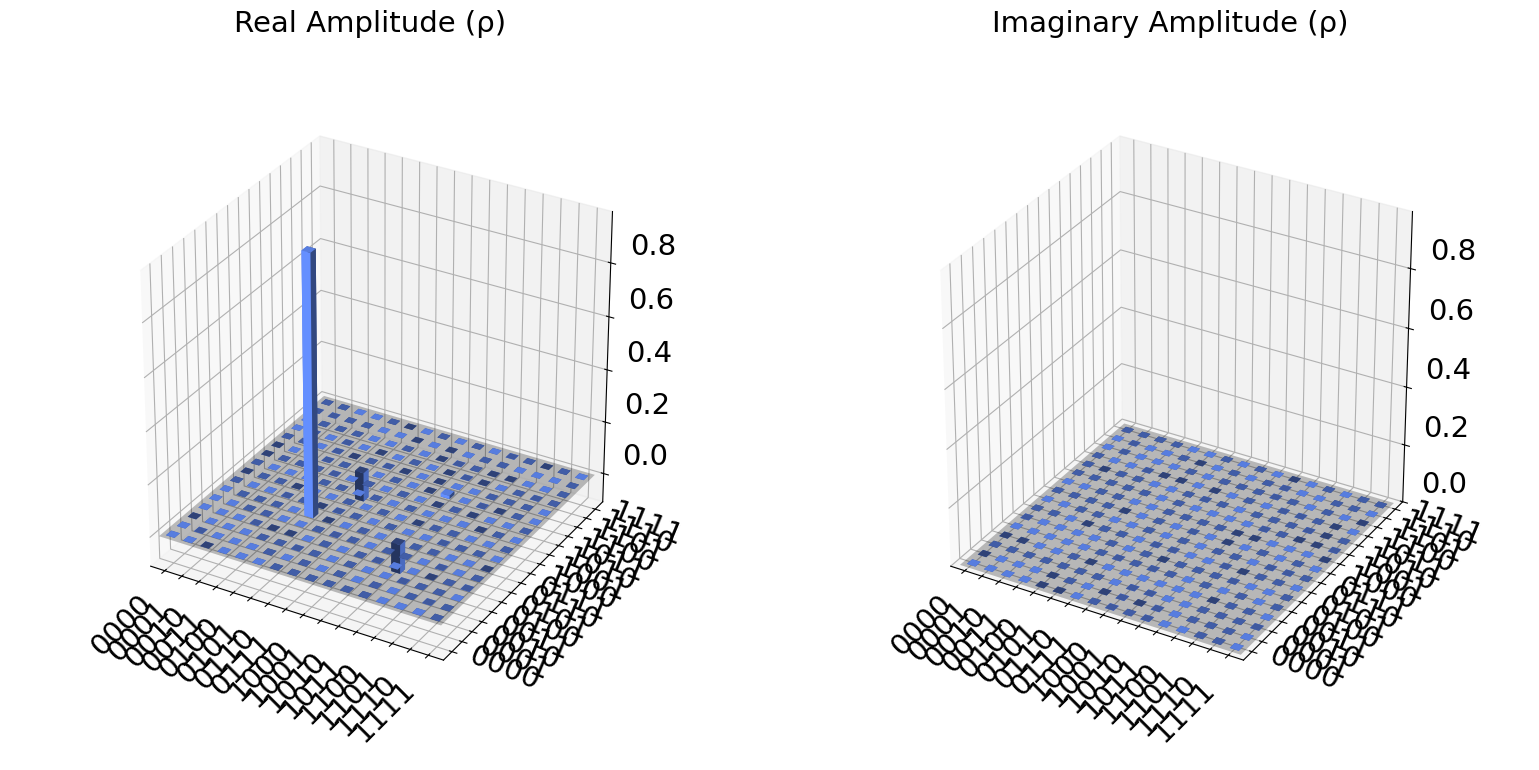

In [39]:
from qiskit.quantum_info import Statevector, DensityMatrix

optimal_ansatz_d_equilibrium.draw('mpl')


Statevector(optimal_ansatz_d_equilibrium).draw('city')




In [28]:
DensityMatrix(optimal_ansatz_d).draw('latex')


<IPython.core.display.Latex object>

In [40]:
ansatz_h2, pauli_ham_h2, prob = initialize_H2_vqe_chemical(intermolecular_distance= 4)

gs_energy_d, optimal_ansatz_d = vqe_chemical_ansatz(estimator=estimator,
                                                                ansatz= ansatz_h2,
                                                                problem= prob)

optimal_ansatz_d.draw('mpl')


Statevector(optimal_ansatz_d).draw('latex')



<IPython.core.display.Latex object>

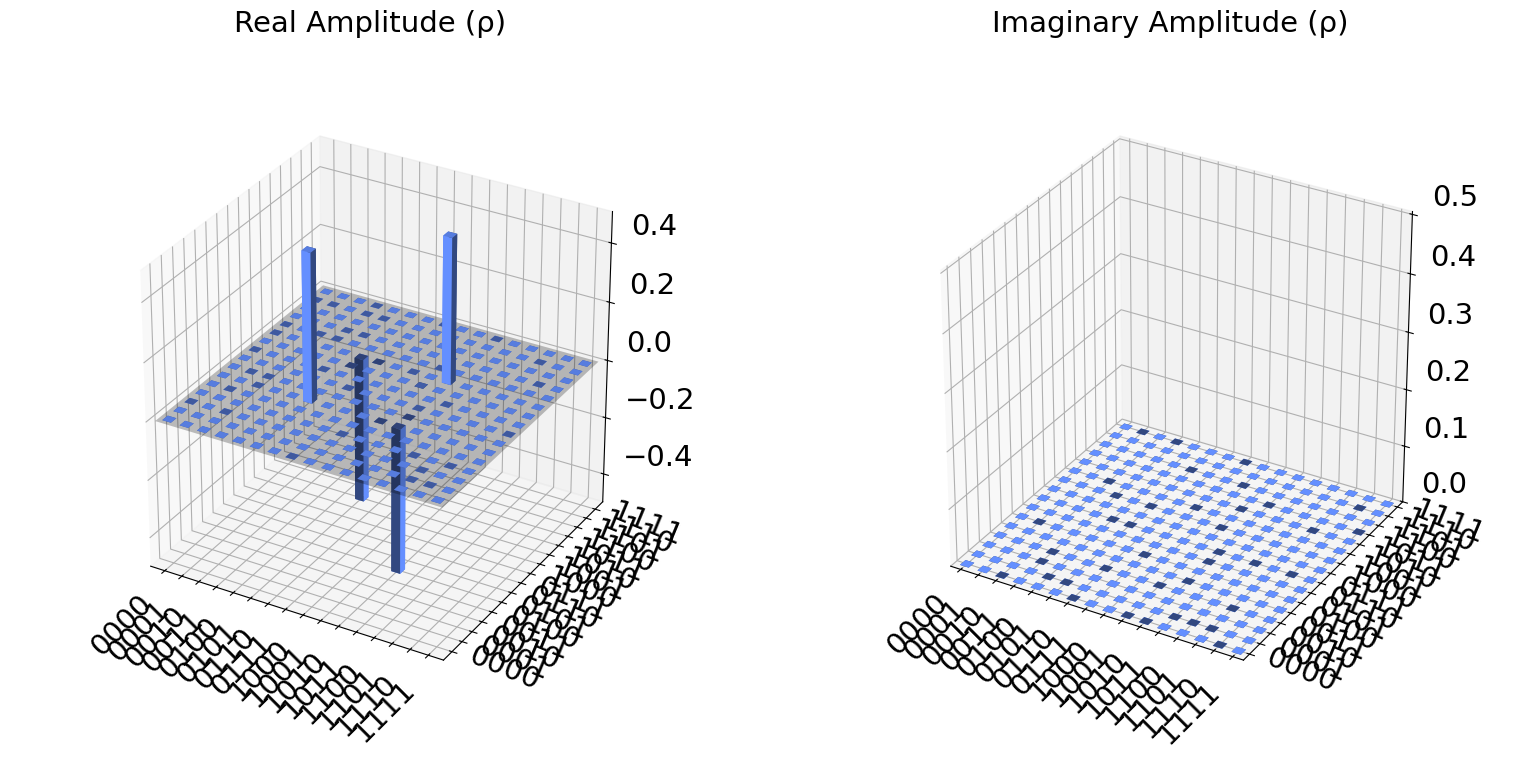

In [41]:
DensityMatrix(optimal_ansatz_d).draw('city')

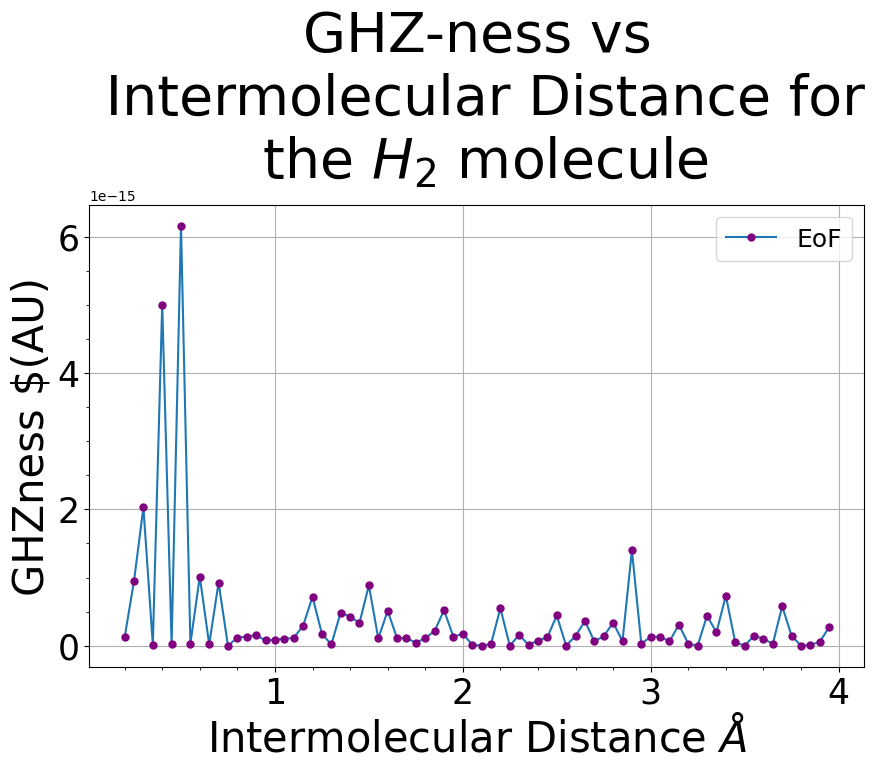

In [ ]:
plt.figure(figsize=(10, 6))
#plt.plot(distances[3:], energiesH2_pt2[3:] , marker='o', linestyle='-', label= 'energy', markeredgecolor= 'orange', markerfacecolor= 'orange' , markersize= 5)
plt.plot(distances[3:], ghzmeasure_pt2[3:], marker='o', linestyle='-', label= 'EoF', markeredgecolor= 'purple', markerfacecolor= 'purple' , markersize= 5)

plt.xlabel(r'Intermolecular Distance $\AA$', fontsize= 30 )
plt.ylabel(r'GHZness $(AU)', fontsize= 30)
plt.title('GHZ-ness vs\n Intermolecular Distance for\n the $H_2$ molecule', fontsize= 40)
plt.grid(True)
plt.legend(fontsize= 18)
plt.minorticks_on()  # Enable minor ticks


plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

plt.show()

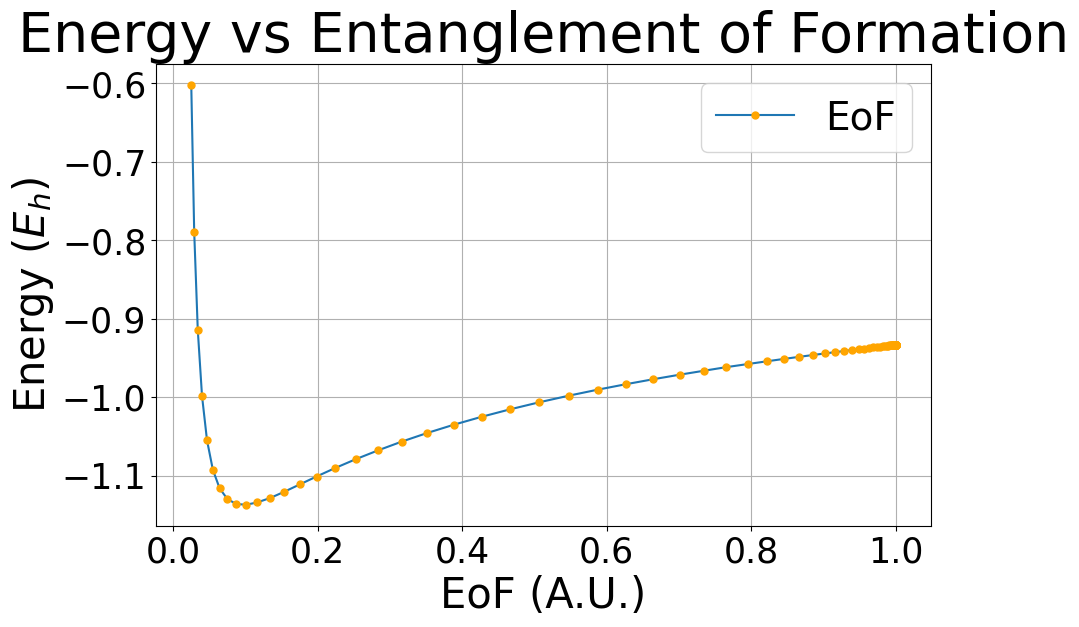

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(entgtotal[5:], energiesH2[5:], marker='o', linestyle='-', label= 'EoF', markeredgecolor= 'orange', markerfacecolor= 'orange' , markersize= 5)
plt.xlabel(r'EoF (A.U.)', fontsize= 30 )
plt.ylabel(r'Energy ($E_h$)', fontsize= 30)
plt.title(r'Energy vs Entanglement of Formation', fontsize= 40)
plt.grid(True)
plt.legend(fontsize= 28)

plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

plt.show()

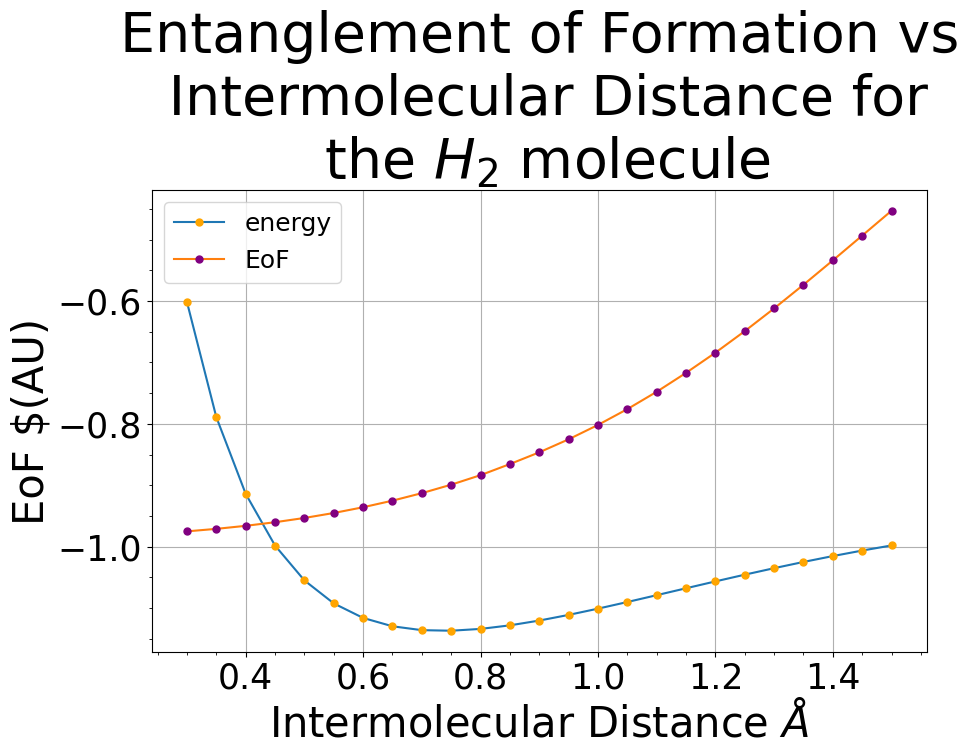

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(distances[5:30], energiesH2_pt2[5:30] , marker='o', linestyle='-', label= 'energy', markeredgecolor= 'orange', markerfacecolor= 'orange' , markersize= 5)
plt.plot(distances[5:30], entgmax_pt2[5:30] - 1, marker='o', linestyle='-', label= 'EoF', markeredgecolor= 'purple', markerfacecolor= 'purple' , markersize= 5)

plt.xlabel(r'Intermolecular Distance $\AA$', fontsize= 30 )
plt.ylabel(r'EoF $(AU)', fontsize= 30)
plt.title('Entanglement of Formation vs\n Intermolecular Distance for\n the $H_2$ molecule', fontsize= 40)
plt.grid(True)
plt.legend(fontsize= 18)
plt.minorticks_on()  # Enable minor ticks


plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

plt.show()

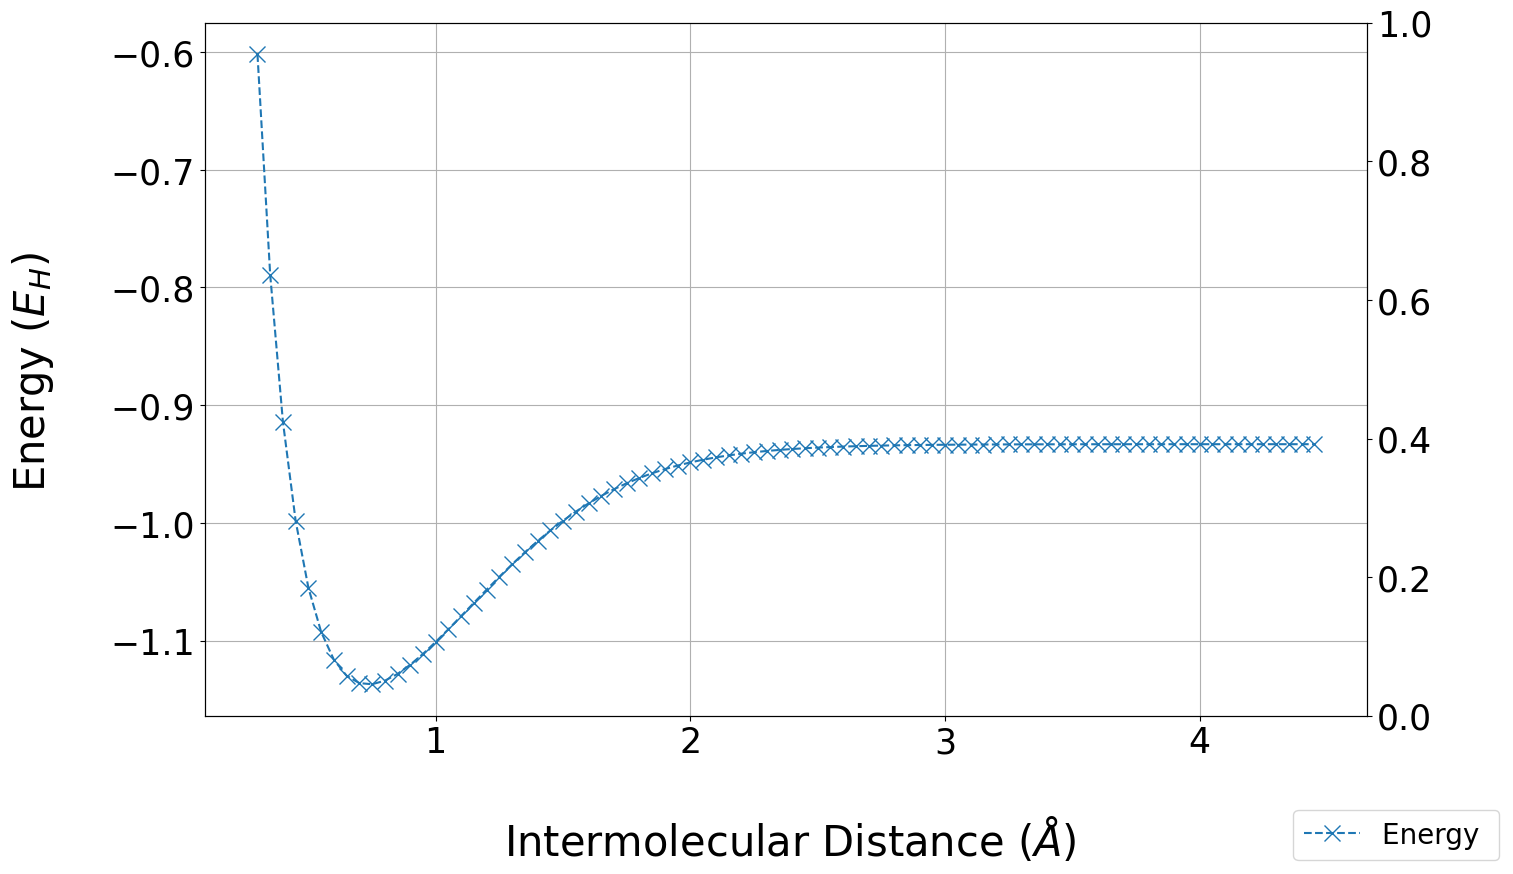

In [ ]:






fig, ax1 = plt.subplots(figsize=(15, 9))


ax1.plot(distances[5:], energiesH2[5:], marker='x', linestyle='--', label= 'Energy ', markersize= 12)

ax1.set_xlabel('\n Intermolecular Distance ($\AA$) ', fontsize= 30 )
ax1.set_ylabel('Energy ($E_H$) \n', fontsize= 30)
#ax1.set_title('State Distances vs Internuclear Distance\n', fontsize= 40)
ax1.grid(True)
ax1.tick_params(axis='y')
plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

ax2 = ax1.twinx()

#ax2.plot(distances[5:], entgmax_pt2[5:], marker='+', linestyle='--',label= 'EoF' , markersize= 12, color= 'tab:orange')
#ax2.set_ylabel('EoF ($A.U.$)',  fontsize= 30)
#ax2.tick_params(axis= 'y')


fig.legend( loc='lower right' ,fontsize= 20)
plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here


#fig.tight_layout()
plt.show()

# Lets select the best ones

In [ ]:
gs_energy = np.min(energiesH2_pt2)

gs_ener_indx = np.where(energiesH2_pt2 == gs_energy)[0][0]

minimal_distance = distances[gs_ener_indx]

print(f'Ground State Energy: {gs_energy} Hartree \n Distance of Equilibrium: {minimal_distance} Armstrongs')

Ground State Energy: -1.137306035695394 Hartree 
 Distance of Equilibrium: 0.7350000000000002 Armstrongs


# Now Study of entanglements, nothing surprising

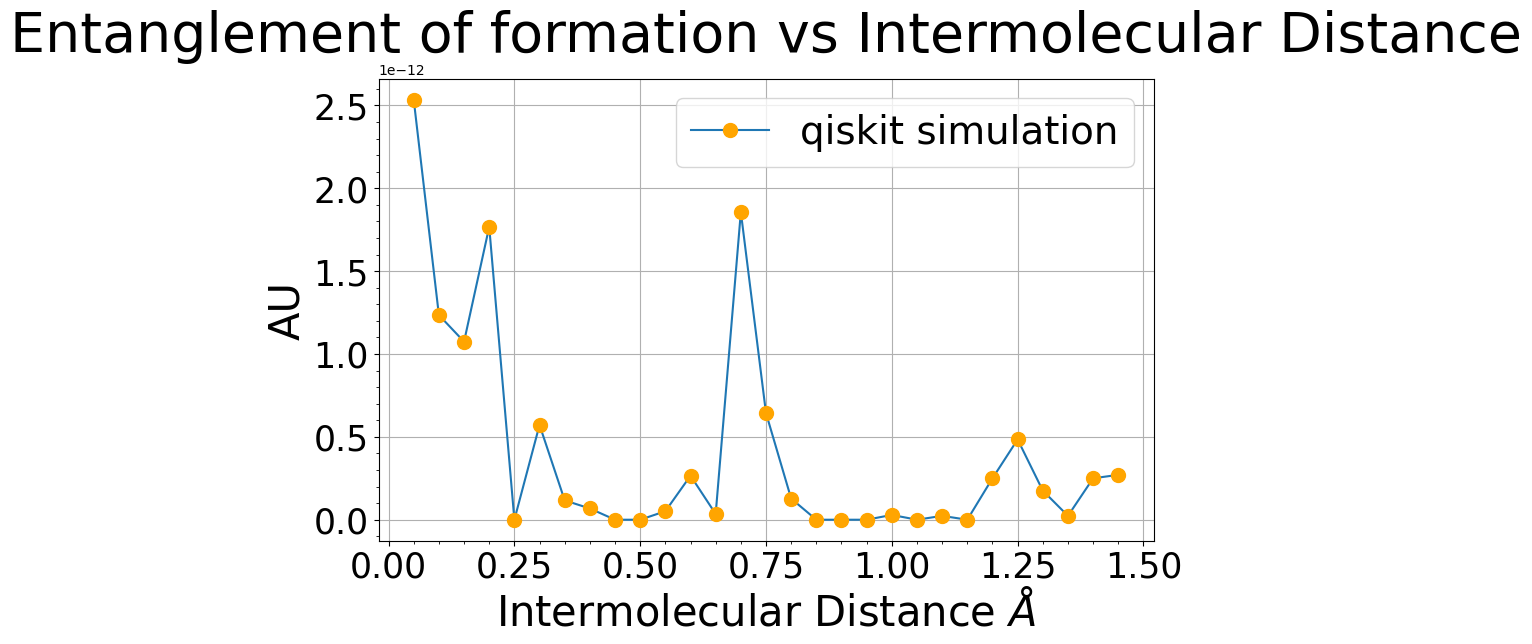

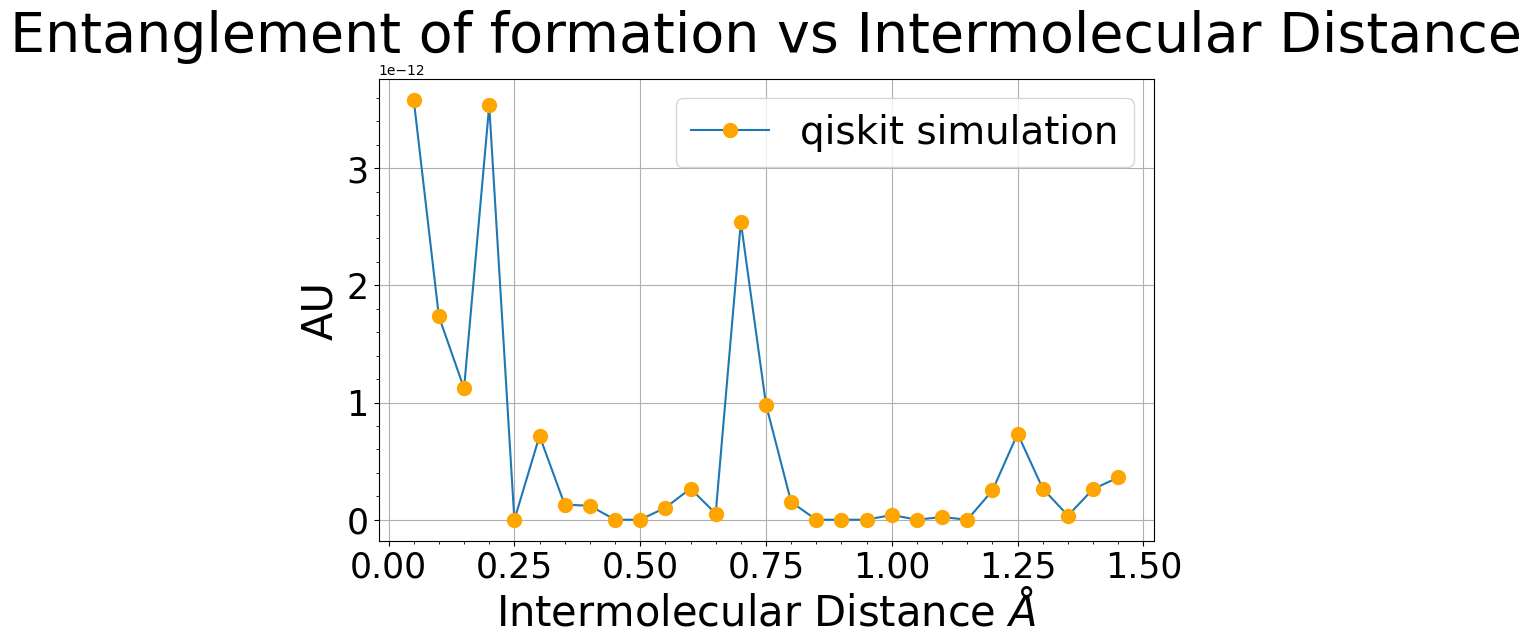

In [ ]:
for data in (entgmax, entgtotal):


    plt.figure(figsize=(10, 6))
    plt.plot(distances, data, marker='o', linestyle='-', label= 'qiskit simulation', markeredgecolor= 'orange', markerfacecolor= 'orange' , markersize= 10)
    plt.xlabel(r'Intermolecular Distance $\AA$', fontsize= 30 )
    plt.ylabel(f'AU', fontsize= 30)
    plt.title(r'Entanglement of formation vs Intermolecular Distance', fontsize= 40)
    plt.minorticks_on()  # Enable minor ticks

    plt.grid(True)
    plt.legend(fontsize= 28)

    plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

    plt.show()


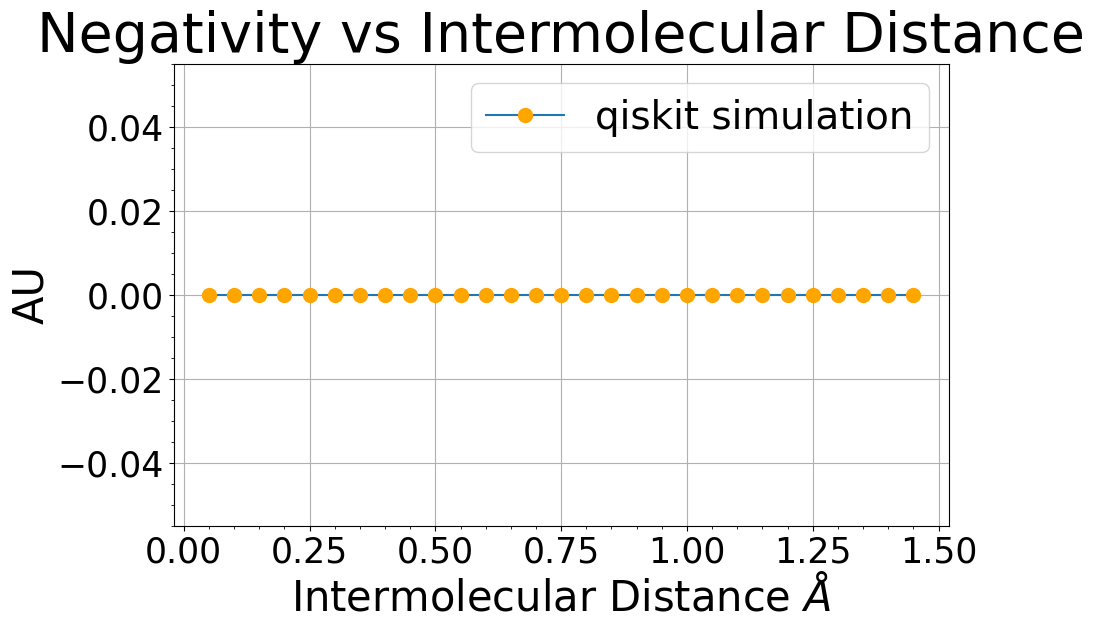

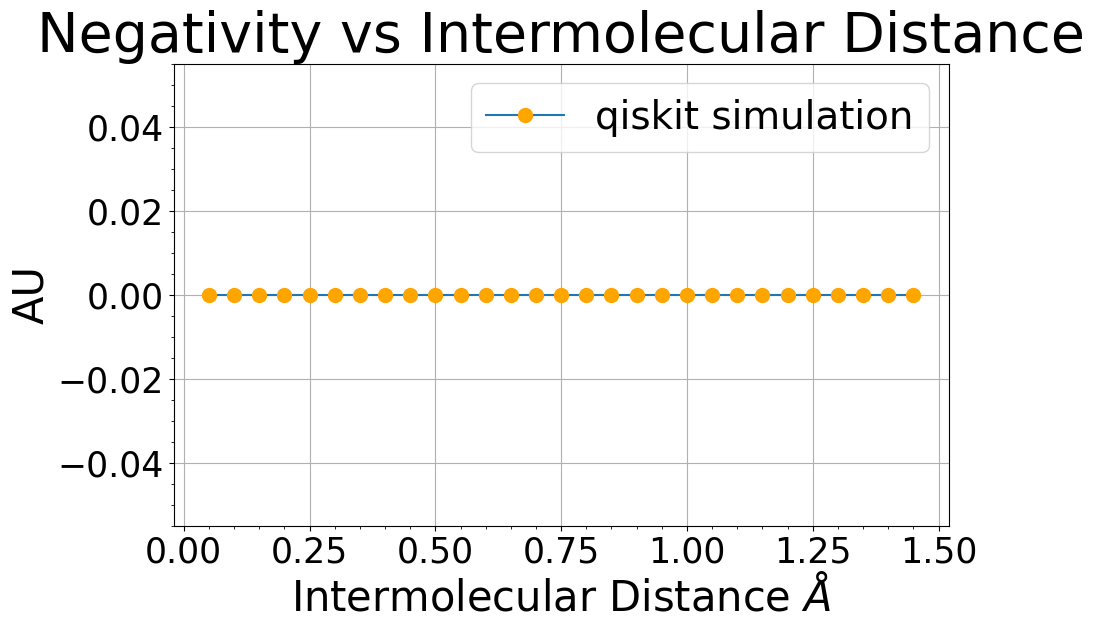

In [ ]:
for data in (negmax, negtotal):


    plt.figure(figsize=(10, 6))
    plt.plot(distances, data, marker='o', linestyle='-', label= 'qiskit simulation', markeredgecolor= 'orange', markerfacecolor= 'orange' , markersize= 10)
    plt.xlabel(r'Intermolecular Distance $\AA$', fontsize= 30 )
    plt.ylabel(f'AU', fontsize= 30)
    plt.title(r'Negativity vs Intermolecular Distance', fontsize= 40)
    plt.minorticks_on()  # Enable minor ticks

    plt.grid(True)
    plt.legend(fontsize= 28)

    plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

    plt.show()

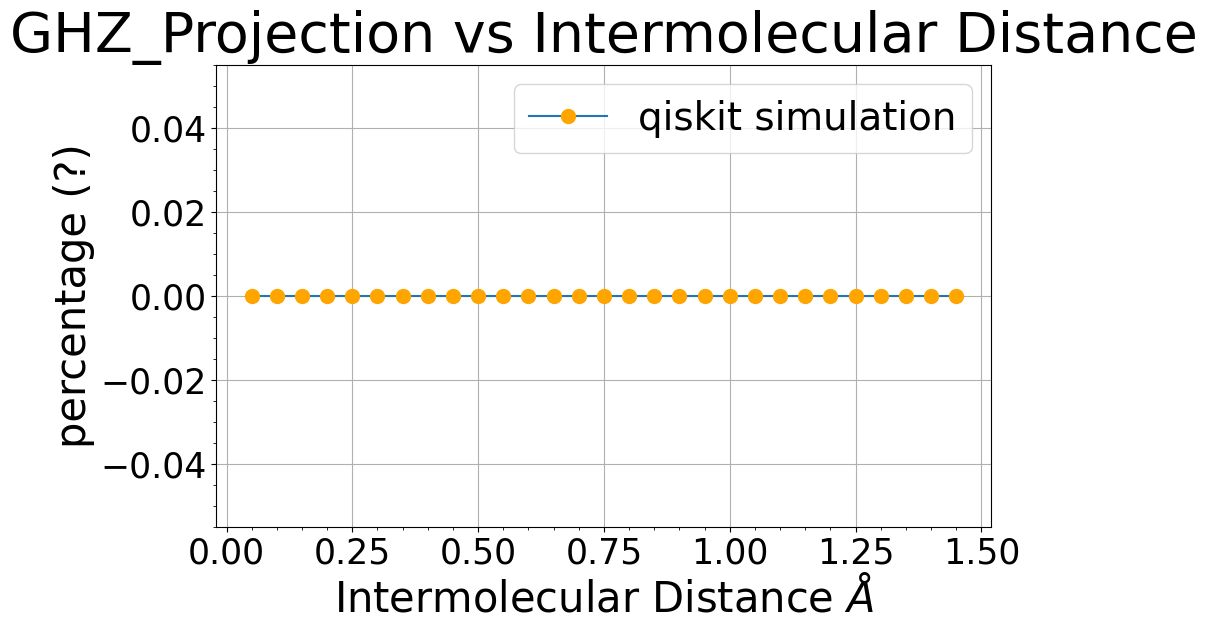

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(distances, ghzmeasure, marker='o', linestyle='-', label= 'qiskit simulation', markeredgecolor= 'orange', markerfacecolor= 'orange' , markersize= 10)
plt.xlabel(r'Intermolecular Distance $\AA$', fontsize= 30 )
plt.ylabel(f'percentage (?)', fontsize= 30)
plt.title(r'GHZ_Projection vs Intermolecular Distance', fontsize= 40)
plt.minorticks_on()  # Enable minor ticks

plt.grid(True)
plt.legend(fontsize= 28)

plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

plt.show()

In [ ]:




from vqe_algorithm import cost_func

cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

#init point:
x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)

backen = AerSimulator()




estimado = Estimator(backend= AerSimulator())
pass_manager = generate_preset_pass_manager(backend= ,
                                            optimization_level= 3)


cost_history_list = []
res_list = []

res = minimize(
    cost_func,
    x0,
    args=(ansatz, 
          ansatz, 
          pauli_hamiltonian, 
          estimado, 
          pass_manager, 
          cost_history_dict, 
          True),
    method= 'cobyla',
    options={'maxiter' : 400}
)

res_list.append(res)

print(cost_history_list["cost_history"])
cost_history_list.append(cost_history_dict["cost_history"])



SyntaxError: invalid syntax (732052110.py, line 18)

In [ ]:
print(cost_history_list)

[[array(-0.84923374), array(-1.24516316), array(-1.34857509), array(-0.49951571), array(-1.27432069), array(-1.40290906), array(-1.28682952), array(-1.27502555), array(-1.70820698), array(-1.81412285), array(-1.72996915), array(-1.85491363), array(-1.84966176), array(-1.84666689), array(-1.85224897), array(-1.87181974), array(-1.87451656), array(-1.8423222), array(-1.86004014), array(-1.8825636), array(-1.8766515), array(-1.88544232), array(-1.88816441), array(-1.88075389), array(-1.88584138), array(-1.88421591), array(-1.88863371), array(-1.88106477), array(-1.88435807), array(-1.88088901), array(-1.88742928), array(-1.8866208), array(-1.88354268), array(-1.88781375), array(-1.8908461), array(-1.89142388), array(-1.88790053), array(-1.89301686), array(-1.88019083), array(-1.88867352), array(-1.88420699), array(-1.88299944), array(-1.88462326), array(-1.88819127), array(-1.88757763), array(-1.88993562)]]


46


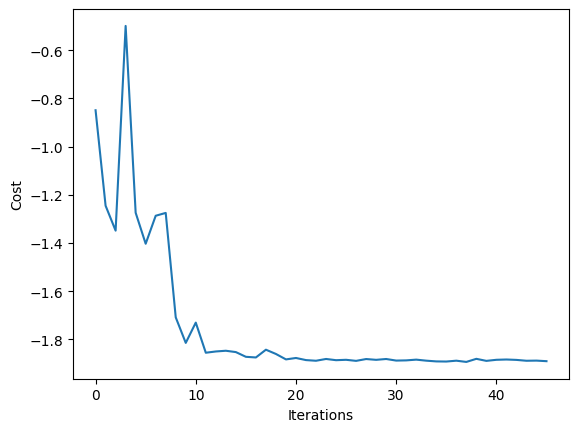

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"] )
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

print(cost_history_dict['iters'])




In [ ]:
distances = np.arange(0.05, 1.5, 0.05)


final_energies_AerSim = []
for d in distances:
    driver = PySCFDriver(atom=f"H 0 0 0; H 0 0 {d}", basis="sto-3g")
    problem = driver.run()

    mapper = JordanWignerMapper()


    hamiltonian = problem.hamiltonian.second_q_op()
    pauli_hamiltonian = mapper.map(hamiltonian)


#then we generate the Ansatz
    init_state = HartreeFock(problem.num_spatial_orbitals,
                         problem.num_particles,
                         mapper)

    ansatz = UCCSD(problem.num_spatial_orbitals,
               problem.num_particles,
               mapper,
               initial_state= init_state)
    
    #initial point x0

    x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
    

    cost_history_list = []
    res_list = []

    res = minimize(
    cost_func,
    x0,
    args=(ansatz, 
          ansatz, 
          pauli_hamiltonian, 
          estimado, 
          pass_manager, 
          cost_history_dict, 
          True),
    method= 'cobyla',
    options={'maxiter' : 400}
    )

    final_energy = cost_history_dict["cost_history"][-1]

    final_energies_AerSim.append(final_energy)


6862


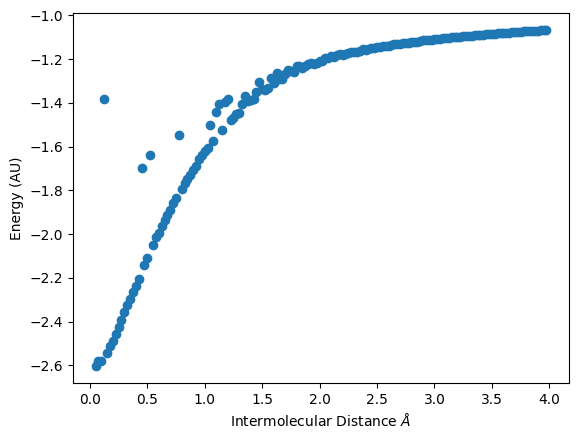

In [ ]:
fig, ax = plt.subplots()
ax.scatter(distances, final_energies_AerSim)
ax.set_xlabel(r'Intermolecular Distance $\AA$')
ax.set_ylabel(r'Energy (AU)')
plt.draw()

print(cost_history_dict['iters'])
